In [ ]:
! pip install PyMaxflow

In [ ]:
# Import necessary libraries
import ee
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import requests
from io import BytesIO
from PIL import Image
import maxflow


In [ ]:

# Authenticate and initialize Google Earth Engine
ee.Authenticate()
ee.Initialize(project='lcbe-5e8c3')



In [ ]:
# Fetch satellite imagery using GEE API
def fetch_satellite_imagery(location):
    # Sentinel-2 surface reflectance dataset
    dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterBounds(location) \
                .filterDate('2023-01-01', '2023-12-31') \
                .sort('CLOUDY_PIXEL_PERCENTAGE', True) \
                .first()
    return dataset

In [ ]:



# Preprocess imagery
def preprocess_imagery(image, location):
    # Select relevant bands (e.g., B4, B3, B2 for RGB)
    bands = ['B4', 'B3', 'B2']
    image = image.select(bands).divide(10000)

    # Define the region of interest
    region = location.buffer(1000).bounds().getInfo()['coordinates']

    # Clip the image to the region of interest
    image = image.clip(location.buffer(1000))

    # Define visualization parameters
    vis_params = {
        'min': 0,
        'max': 0.3,
        'bands': bands
    }

    # Get the URL for the thumbnail image with higher resolution
    url = image.getThumbUrl({'region': region, 'dimensions': '1024x1024', **vis_params})

    return url


In [ ]:


# Download image from URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


In [ ]:

# Segment environmental features using maxflow (MRF)
def segment_features(img_array):
    # Convert image to grayscale
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    # Create a binary mask for demonstration
    _, binary_mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Create the graph
    g = maxflow.Graph[int](0, 0)
    nodeids = g.add_grid_nodes(binary_mask.shape)

    # Structure to add edges (4-connectivity)
    structure = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]])

    # Add edges with the weight inversely proportional to intensity difference
    g.add_grid_edges(nodeids, weights=50, structure=structure, symmetric=True)

    # Add terminal edges with unary potentials
    g.add_grid_tedges(nodeids, binary_mask, 255 - binary_mask)

    # Perform the max-flow/min-cut
    g.maxflow()
    segmented = g.get_grid_segments(nodeids)

    # Convert the segmentation result to a binary image
    segmented_image = np.where(segmented, 255, 0).astype(np.uint8)

    return img_array, segmented_image



In [ ]:
# Visualize segmented features alongside the original image
def visualize_features(original_image, segmented_image):
    plt.figure(figsize=(15, 7))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    # Display the segmented image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.imshow(segmented_image, alpha=0.5, cmap='jet')
    plt.title('Segmented Image')

    # Create a legend for the segmented image
    legend_patches = [Patch(color='blue', label='Forests'),
                      Patch(color='green', label='Grassy Areas')]
    plt.legend(handles=legend_patches, loc='lower right')

    plt.show()

In [ ]:
# Retrieve elevation data
def get_elevation(location):
    elevation = ee.Image('USGS/SRTMGL1_003').sample(location, 30).first().get('elevation').getInfo()
    return elevation


In [ ]:
latlong = [ 38.762663, 9.039814]
location = ee.Geometry.Point(latlong)


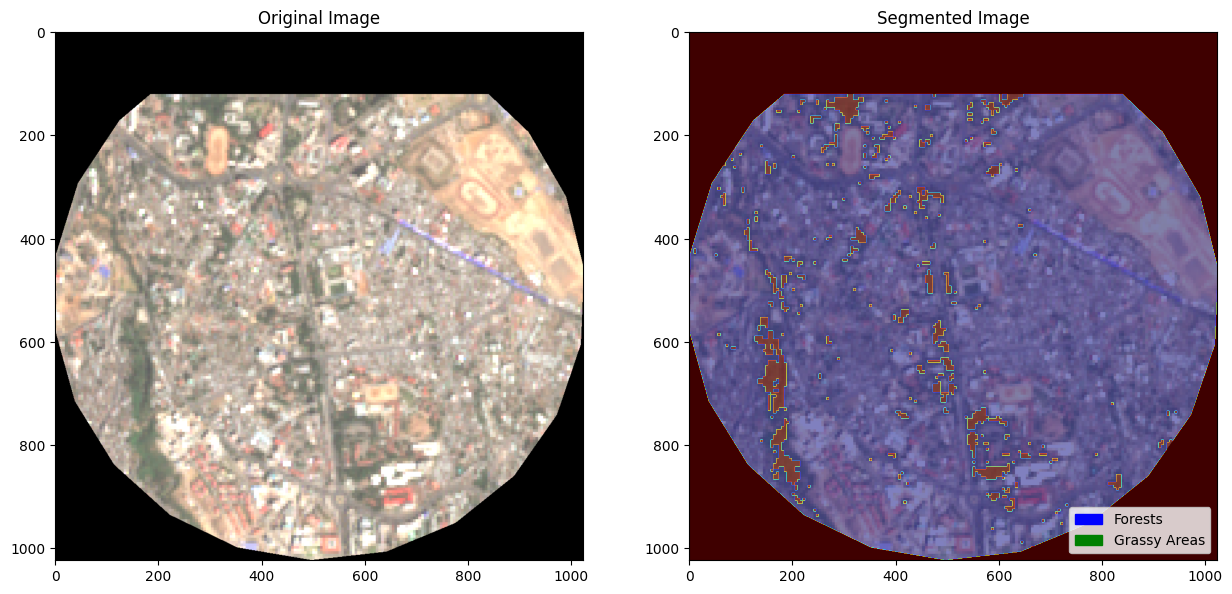

Elevation at the specified location: 2476 meters


In [ ]:
# Fetch and preprocess satellite imagery
image = fetch_satellite_imagery(location)
image_url = preprocess_imagery(image, location)

# Download and segment features
img_array = download_image(image_url)
img_array, segmented = segment_features(img_array)

# Visualize features
visualize_features(img_array, segmented)

# Retrieve and print elevation data
elevation = get_elevation(location)
print(f'Elevation at the specified location: {elevation} meters')



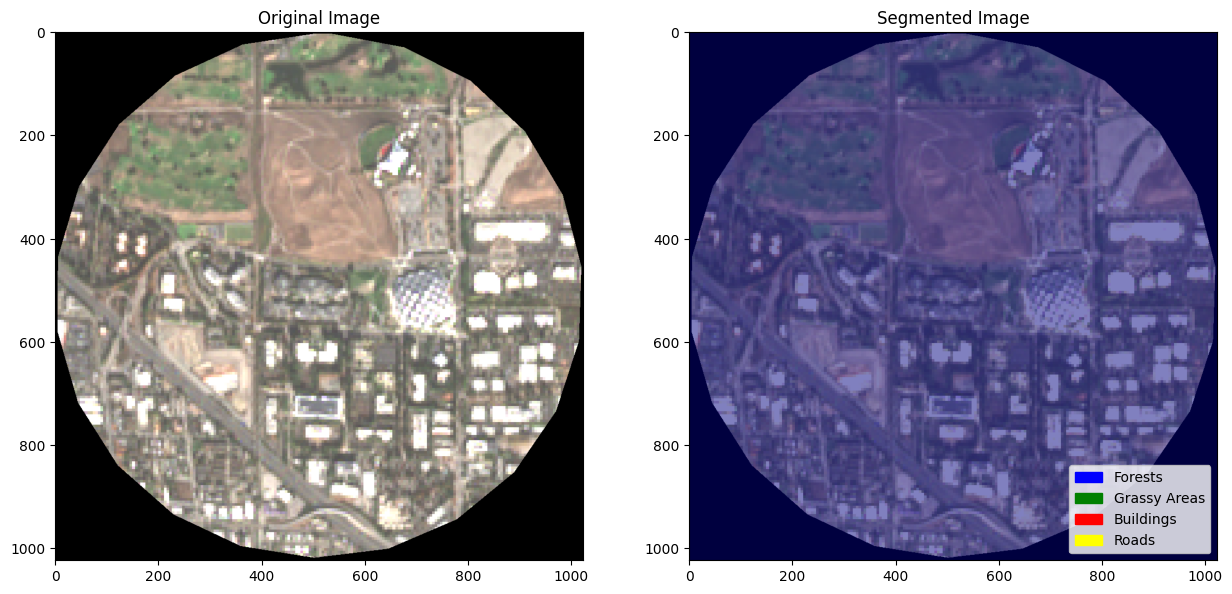

Elevation at the specified location: 8 meters


In [ ]:
# Import necessary libraries
import ee
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import requests
from io import BytesIO
from PIL import Image
import maxflow

# Authenticate and initialize Google Earth Engine
ee.Authenticate()
ee.Initialize(project='lcbe-5e8c3')

# Define the specified location coordinates (latitude, longitude)
longitude = -122.084
latitude = 37.422
location = ee.Geometry.Point([longitude, latitude])

# Fetch satellite imagery using GEE API
def fetch_satellite_imagery(location):
    # Sentinel-2 surface reflectance dataset
    dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterBounds(location) \
                .filterDate('2023-01-01', '2023-12-31') \
                .sort('CLOUDY_PIXEL_PERCENTAGE', True) \
                .first()
    return dataset

# Preprocess imagery
def preprocess_imagery(image, location):
    # Select relevant bands (e.g., B4, B3, B2 for RGB)
    bands = ['B4', 'B3', 'B2']
    image = image.select(bands).divide(10000)

    # Define the region of interest
    region = location.buffer(1000).bounds().getInfo()['coordinates']

    # Clip the image to the region of interest
    image = image.clip(location.buffer(1000))

    # Define visualization parameters
    vis_params = {
        'min': 0,
        'max': 0.3,
        'bands': bands
    }

    # Get the URL for the thumbnail image with higher resolution
    url = image.getThumbUrl({'region': region, 'dimensions': '1024x1024', **vis_params})

    return url

# Download image from URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Segment environmental features using maxflow (MRF)
def segment_features(img_array):
    # Convert image to grayscale
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    # Create initial masks for different classes (this is a placeholder, replace with actual classification)
    _, forest_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    _, grass_mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
    _, building_mask = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    _, road_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Combine masks into a single array with different labels
    labels = np.zeros_like(gray)
    labels[forest_mask == 255] = 1  # Forests
    labels[grass_mask == 255] = 2  # Grass
    labels[building_mask == 255] = 3  # Buildings
    labels[road_mask == 255] = 4  # Roads

    # Create unary potentials for each class (5 classes, including background)
    num_classes = 5
    unary = np.zeros((gray.shape[0], gray.shape[1], num_classes), dtype=np.int32)
    for i in range(num_classes):
        unary[..., i] = np.where(labels == i, 0, 10)

    # Pairwise potential (cost of neighboring pixels having different labels)
    pairwise = np.ones((num_classes, num_classes), dtype=np.int32) - np.eye(num_classes, dtype=np.int32)

    # Create the graph
    g = maxflow.Graph[int](0, 0)
    nodeids = g.add_grid_nodes(gray.shape)

    # Structure to add edges (4-connectivity)
    structure = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]])

    # Add edges with the weight inversely proportional to intensity difference
    g.add_grid_edges(nodeids, weights=50, structure=structure, symmetric=True)

    # Add terminal edges with unary potentials
    for i in range(num_classes):
        g.add_grid_tedges(nodeids, unary[..., i], 255 - unary[..., i])

    # Perform the max-flow/min-cut
    g.maxflow()
    segmented = g.get_grid_segments(nodeids)

    # Convert the segmentation result to an image with different labels
    segmented_image = (segmented * 255).astype(np.uint8)

    return img_array, segmented_image

# Visualize segmented features alongside the original image
def visualize_features(original_image, segmented_image):
    plt.figure(figsize=(15, 7))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    # Display the segmented image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.imshow(segmented_image, alpha=0.5, cmap='jet')
    plt.title('Segmented Image')

    # Create a legend for the segmented image
    legend_patches = [
        Patch(color='blue', label='Forests'),
        Patch(color='green', label='Grassy Areas'),
        Patch(color='red', label='Buildings'),
        Patch(color='yellow', label='Roads')
    ]
    plt.legend(handles=legend_patches, loc='lower right')

    plt.show()

# Retrieve elevation data
def get_elevation(location):
    elevation = ee.Image('USGS/SRTMGL1_003').sample(location, 30).first().get('elevation').getInfo()
    return elevation

# Main function to run the pipeline
def main(location):
    # Fetch and preprocess satellite imagery
    image = fetch_satellite_imagery(location)
    image_url = preprocess_imagery(image, location)

    # Download and segment features
    img_array = download_image(image_url)
    img_array, segmented = segment_features(img_array)

    # Visualize features
    visualize_features(img_array, segmented)

    # Retrieve and print elevation data
    elevation = get_elevation(location)
    print(f'Elevation at the specified location: {elevation} meters')

# Run the pipeline
if __name__ == "__main__":
    main(location)


In [ ]:
# Import necessary libraries
import ee
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import requests
from io import BytesIO
from PIL import Image
import maxflow

# Authenticate and initialize Google Earth Engine
ee.Authenticate()
ee.Initialize(project='lcbe-5e8c3')

# Fetch satellite imagery using GEE API
def fetch_satellite_imagery(location):
    dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterBounds(location) \
                .filterDate('2023-01-01', '2023-12-31') \
                .sort('CLOUDY_PIXEL_PERCENTAGE', True) \
                .first()
    return dataset

# Preprocess imagery
def preprocess_imagery(image, location, buffer_size=1000, resolution='1024x1024'):
    bands = ['B4', 'B3', 'B2']
    image = image.select(bands).divide(10000)

    # Define the region of interest
    region = location.buffer(buffer_size).bounds().getInfo()['coordinates']
    image = image.clip(location.buffer(buffer_size))

    vis_params = {
        'min': 0,
        'max': 0.3,
        'bands': bands
    }

    url = image.getThumbUrl({'region': region, 'dimensions': resolution, **vis_params})
    return url

# Download image from URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(cv2.imread('/gdrive/MyDrive/ml/Yeka.jpg'), cv2.COLOR_RGB2BGR)

# Segment environmental features using maxflow (MRF)
def segment_features(img_array):
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    g = maxflow.Graph[int](0, 0)
    nodeids = g.add_grid_nodes(binary_mask.shape)
    structure = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    g.add_grid_edges(nodeids, weights=50, structure=structure, symmetric=True)
    g.add_grid_tedges(nodeids, binary_mask, 255 - binary_mask)
    g.maxflow()
    segmented = g.get_grid_segments(nodeids)
    segmented_image = np.where(segmented, 255, 0).astype(np.uint8)

    return img_array, segmented_image

# Visualize segmented features alongside the original image
def visualize_features(original_image, segmented_image):
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.imshow(segmented_image, alpha=0.5, cmap='jet')
    plt.title('Segmented Image')

    legend_patches = [Patch(color='blue', label='Forests'),
                      Patch(color='green', label='Grassy Areas'),
                      Patch(color='red', label='Buildings'),
                      Patch(color='gray', label='Roads')]
    plt.legend(handles=legend_patches, loc='lower right')

    plt.show()

# Retrieve elevation data
def get_elevation(location):
    elevation = ee.Image('USGS/SRTMGL1_003').sample(location, 30).first().get('elevation').getInfo()
    return elevation

latlong = [38.762663, 9.039814]
location = ee.Geometry.Point(latlong)

# Adjust buffer size and resolution for better image quality
buffer_size = 500  # Adjust buffer size to 500 meters
resolution = '2048x2048'  # Increase resolution for better quality

image = fetch_satellite_imagery(location)
image_url = preprocess_imagery(image, location, buffer_size, resolution)
img_array = download_image(image_url)
img_array, segmented = segment_features(img_array)
visualize_features(img_array, segmented)
elevation = get_elevation(location)
print(f'Elevation at the specified location: {elevation} meters')


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Mounted at /gdrive
/gdrive
